In [ ]:
from libaries import *
from data_loading import findFiles,LoadDataSignals
from global_parameters import *
from peak_to_peak_detection import *
from Data_Denoising.data_denoising import *
from Data_Denoising.time_synchronization import *
from Data_Denoising.moving_average_filter import *
from Data_Denoising.derivative_filtering import apply_improved_derivative_filter
from Data_Denoising.dc_offset_removal import *
from plotting_module.signal_plot import *
from Data_Denoising.bandpass_filtering import *
from waveform_detection.detect_waveform import *
from waveform_detection.detect_waveform import *


In [4]:
def normalize_min_max(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


#### Extract relevant files for processing


In [5]:
waveforms=["sin","square"]
periods= ["1","5","9"]

expected_waveform= waveforms[0]
expected_periods= periods[0]

In [6]:

unique_file_list= findFiles(expected_waveform,expected_periods,sample_number=1)
unique_file_list

['/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/23rd may/51000mg/23rdmaynewsetup1percentage25DegreeTemperatureMarch-ram-WaterSugar_mid_solution-51000mg-sin1-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/23rd may/omg/23rdmaynewsetup1percentage25DegreeTemperatureMarch-ram-WaterSugar_mid_solution-0mg-sin1-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/23rd may/17000mg/23rdmaynewsetup1percentage25DegreeTemperatureMarch-ram-WaterSugar_mid_solution-17000mg-sin1-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/23rd may/34000mg/23rdmaynewsetup1percentage25DegreeTemperatureMarch-ram-WaterSugar_mid_solution-34000mg-sin1-pure_water_solution_1.mat']

#### Data Loading

In [7]:
raw,Concentration,actual_waveform,periods=LoadDataSignals(unique_file_list[2],time_axis_start=0,time_axis_end=16000)
raw.shape


(100, 2, 16000)

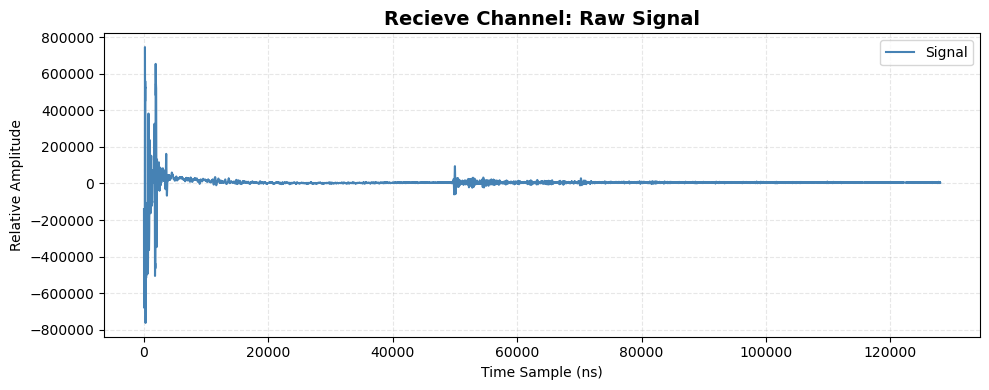

In [8]:
signal_plot(raw[0,1,:],start=0,end=16000,title="Recieve Channel: Raw Signal")

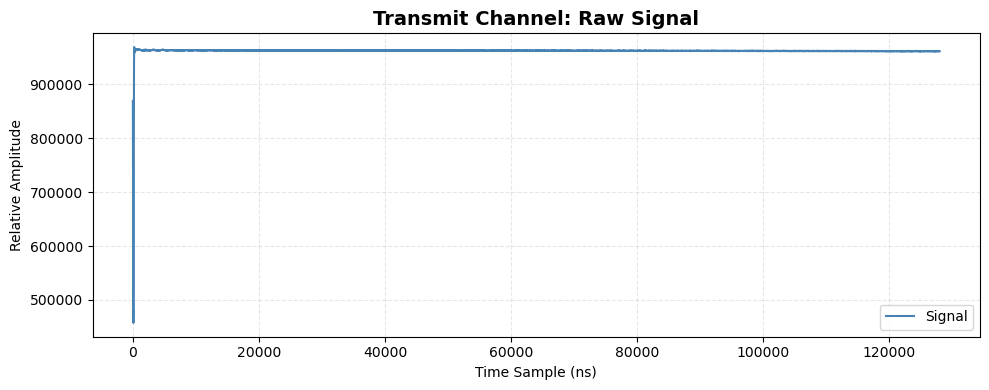

In [9]:
signal_plot(raw[0,0,:],start=0,end=16000,title="Transmit Channel: Raw Signal")

## Data Processing

#### DC offset removal

In [10]:
transmit, receive= dc_offset_removal(raw)

DC Offset Removal - Transmit: (100, 16000)  | Receive: (100, 16000)


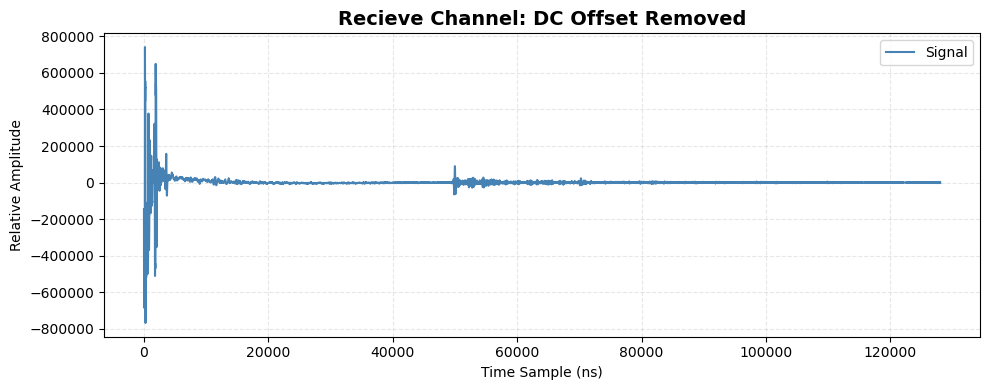

In [11]:
signal_plot(receive[0,:],start=0,end=16000,title="Recieve Channel: DC Offset Removed")

# Different Filtering Techniques in Time Domain

#### Time Synchronized Averaging (Experiments=100)

In [12]:
receive.shape

(100, 16000)

In [13]:
transmit_averaged_signal,recieve_averaged_signal=time_synchronized_averaging(transmit,receive,threshold=500000)

Transmit Valid signals after filtering: (33, 16000)
Recieve Valid signals after filtering: (33, 16000)


In [14]:
recieve_averaged_signal.shape

(1, 16000)

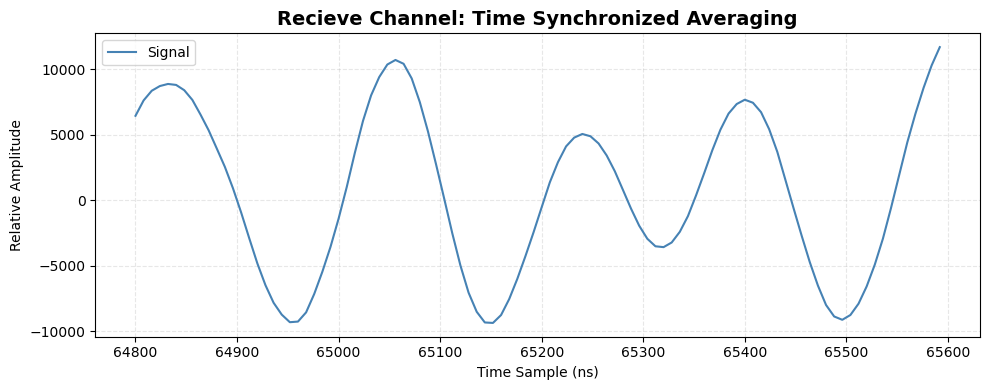

In [15]:
signal_plot(recieve_averaged_signal[0],start=8100,end=8200,title="Recieve Channel: Time Synchronized Averaging")

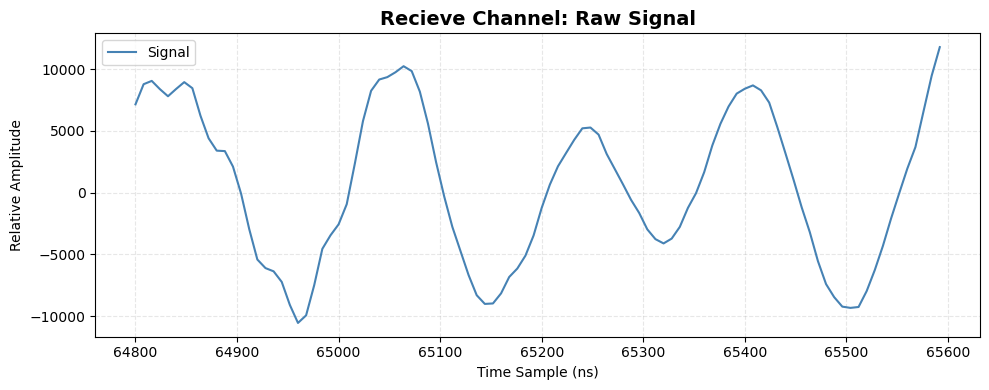

In [16]:
signal_plot(receive[0,:],start=8100,end=8200,title="Recieve Channel: Raw Signal")

#### Moving Average : Hanning filter or Triangular Filter

In [17]:
transmit_filtered_hanning = batch_apply_hanning_filter(transmit)
recieve_filtered_hanning = batch_apply_hanning_filter(receive)

In [18]:
# Print shape to verify
print("Hanning filter Transmit shape:", transmit_filtered_hanning.shape) 
print("Hanning filter Recieve shape:", recieve_filtered_hanning.shape) 

Hanning filter Transmit shape: (100, 16000)
Hanning filter Recieve shape: (100, 16000)


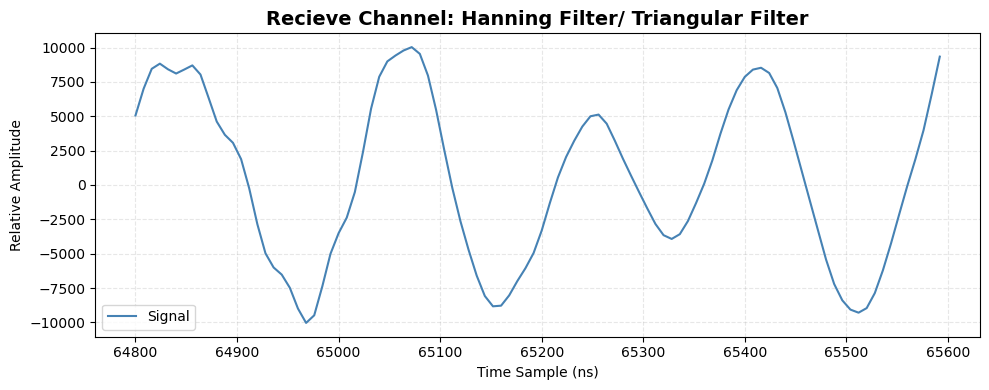

In [19]:
signal_plot(recieve_filtered_hanning[0],start=8100,end=8200,title="Recieve Channel: Hanning Filter/ Triangular Filter")

#### Uniform Moving Average

In [20]:
transmit_uniform_moving_avg=apply_uniform_moving_average_filter(transmit, window_size=11)
recieve_uniform_moving_avg=apply_uniform_moving_average_filter(receive, window_size=11)


In [21]:
recieve_uniform_moving_avg.shape

(100, 16000)

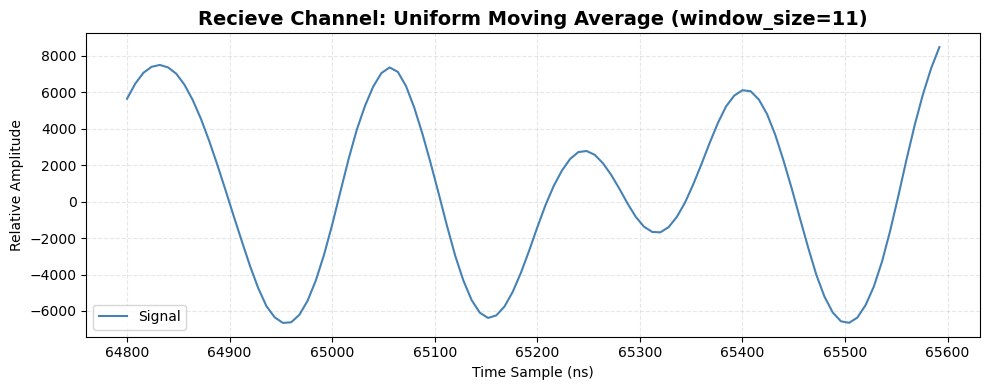

In [22]:
signal_plot(recieve_uniform_moving_avg[0],start=8100,end=8200,title="Recieve Channel: Uniform Moving Average (window_size=11)")

#### Derivative Filter

In [23]:
fs = 125e6  # Sampling frequency in Hz
T = 1 / fs  # Sampling period in seconds

In [24]:
transmit_filtered_derivative=apply_improved_derivative_filter(transmit, T=T)
receive_filtered_derivative=apply_improved_derivative_filter(receive, T=T)


In [25]:
receive_filtered_derivative.shape

(100, 16000)

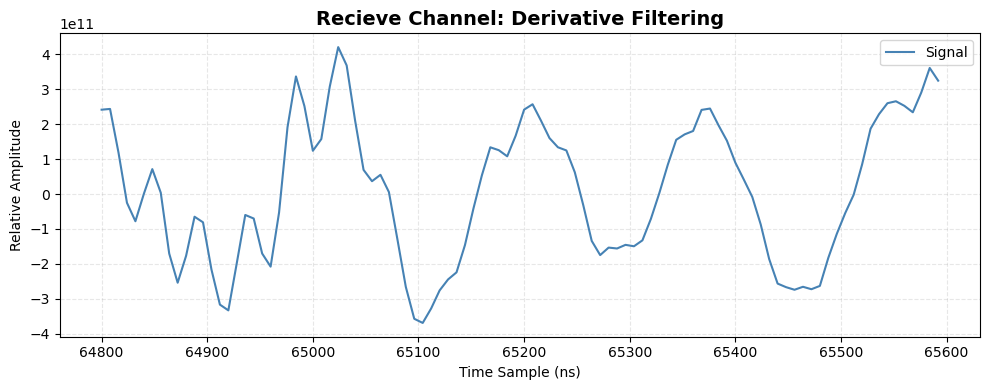

In [26]:
signal_plot(receive_filtered_derivative[0,:],start=8100,end=8200,title="Recieve Channel: Derivative Filtering")

### For smoothning of derivative filter, a uniform average filter is being applied

In [27]:
receive_filtered_derivative_smoothened=apply_uniform_moving_average_filter(receive_filtered_derivative, window_size=11)


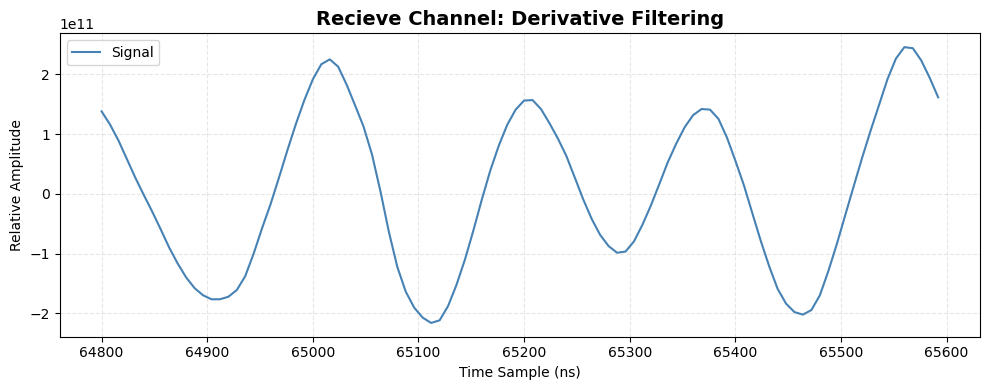

In [28]:
signal_plot(receive_filtered_derivative_smoothened[0,:],start=8100,end=8200,title="Recieve Channel: Derivative Filtering")

#### High Pass Filter

In [29]:

def highpass_filter(data, cutoff, fs, order=5):
    """
    Apply a high-pass Butterworth filter to a 2D signal array.
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    # Design Butterworth high-pass filter
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    # Apply filter to each signal
    filtered_data = filtfilt(b, a, data, axis=1)
    return filtered_data


In [30]:
cutoff = 1_000_000  # 1 MHz
order = 1

recieve_highpass_filtered = highpass_filter(receive, cutoff, fs, order)


In [31]:
recieve_highpass_filtered.shape

(100, 16000)

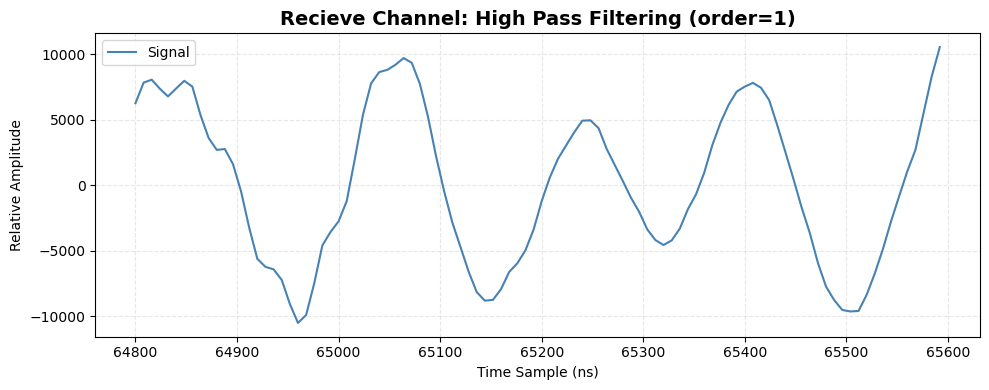

In [32]:
signal_plot(recieve_highpass_filtered[0,:],start=8100,end=8200,title="Recieve Channel: High Pass Filtering (order=1)")

### Bandpass Filter

In [33]:
start=0
end=16000

In [34]:
bandpassed_receive = apply_bandpass_filter(receive[0, start:end], fs, 1e6, 6.5e6)
bandpassed_avg = apply_bandpass_filter(recieve_averaged_signal[0, start:end], fs, 4e6, 6e6)
bandpassed_hanning = apply_bandpass_filter(recieve_filtered_hanning[0, start:end], fs, 4e6, 6e6)


In [35]:
bandpassed_receive.shape

(16000,)

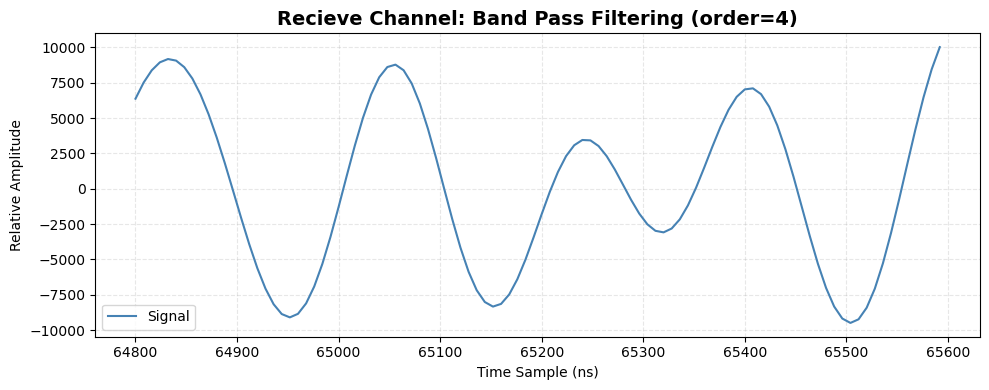

In [36]:

signal_plot(bandpassed_receive[:],start=8100,end=8200,title="Recieve Channel: Band Pass Filtering (order=4)")

#### Data Plotting (For Testing)

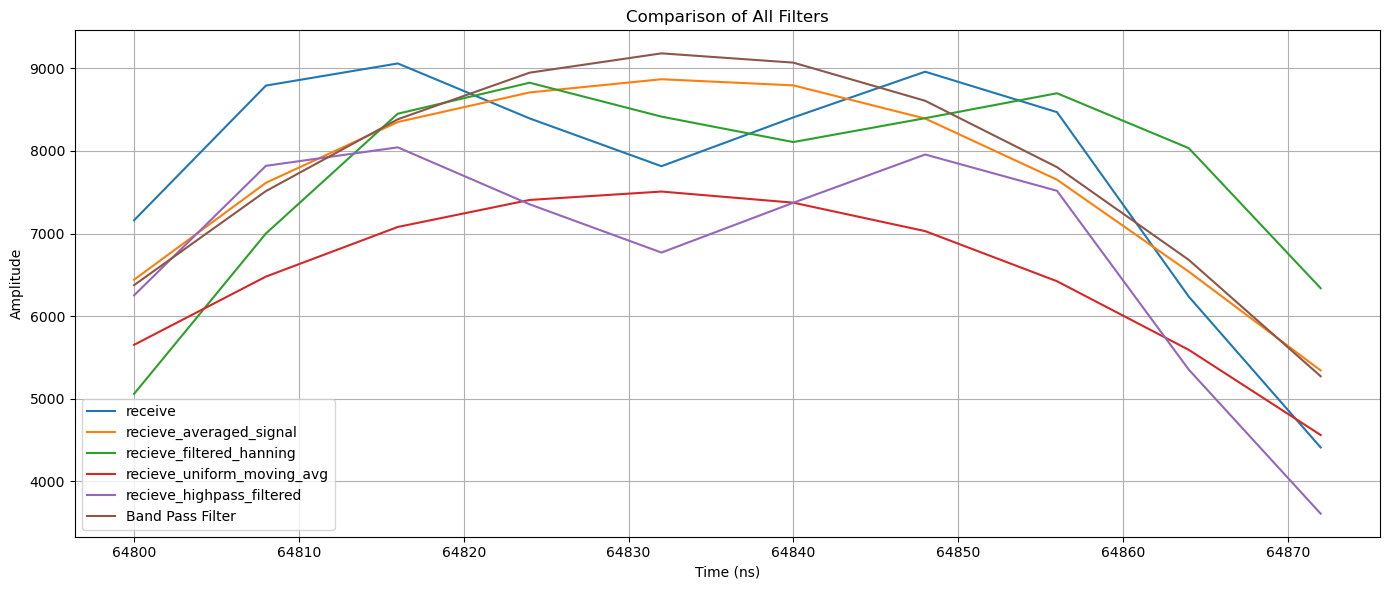

In [37]:
start=0
end=16000
Ts_ns = 1e9 / fs  # Sampling period in nanoseconds
time = np.arange(start, end) * Ts_ns

# Time setup again
zoom_local_start = 8100 - start
zoom_local_end = 8110 - start
zoom_time = time[zoom_local_start:zoom_local_end]

# Scale derivative for fair visual comparison
scaled_derivative = receive_filtered_derivative_smoothened[0, zoom_local_start:zoom_local_end] / 1e12  # Trillions to hundreds

plt.figure(figsize=(14, 6))

plt.plot(zoom_time, receive[0, zoom_local_start + start : zoom_local_end + start], label='receive')
plt.plot(zoom_time, recieve_averaged_signal[0, zoom_local_start:zoom_local_end], label='recieve_averaged_signal')
plt.plot(zoom_time, recieve_filtered_hanning[0, zoom_local_start:zoom_local_end], label='recieve_filtered_hanning')
plt.plot(zoom_time, recieve_uniform_moving_avg[0, zoom_local_start:zoom_local_end], label='recieve_uniform_moving_avg')
plt.plot(zoom_time, recieve_highpass_filtered[0, zoom_local_start:zoom_local_end], label='recieve_highpass_filtered')
plt.plot(zoom_time, bandpassed_receive[zoom_local_start:zoom_local_end], label='Band Pass Filter')


plt.title("Comparison of All Filters")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Echo Detection

### Pan-Tompkins Inspired Pipeline / Pan–Tompkins algorithm


In [38]:
bandpassed_receive.shape

(16000,)

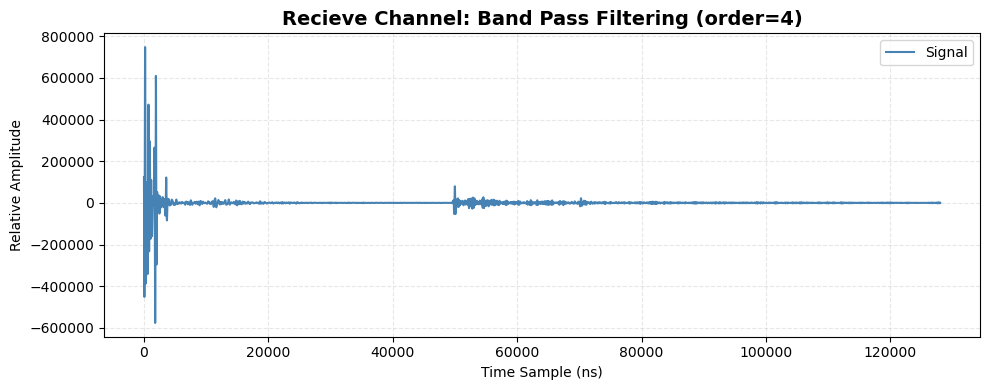

In [39]:
signal_plot(bandpassed_receive[:],start=0,end=16000,title="Recieve Channel: Band Pass Filtering (order=4)")

In [40]:
echo_derivative_filtered_data=apply_improved_derivative_filter(bandpassed_receive,T=T)

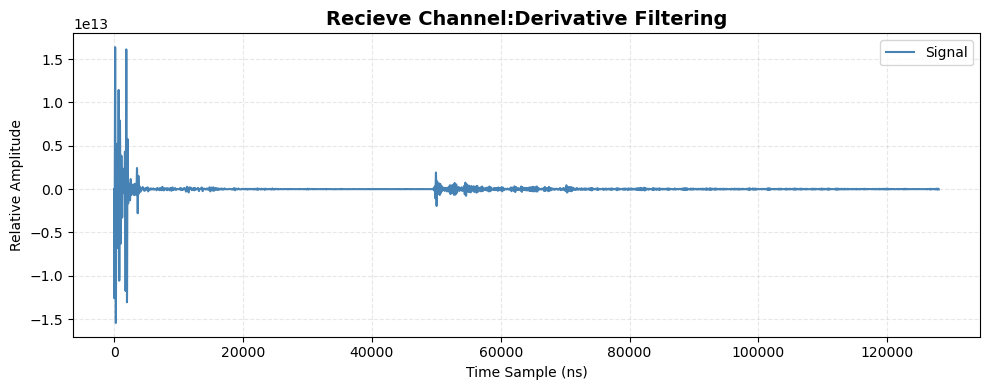

In [41]:
signal_plot(echo_derivative_filtered_data[:],start=0,end=16000,title="Recieve Channel:Derivative Filtering")

In [42]:
normalized_echo = normalize_min_max(echo_derivative_filtered_data)


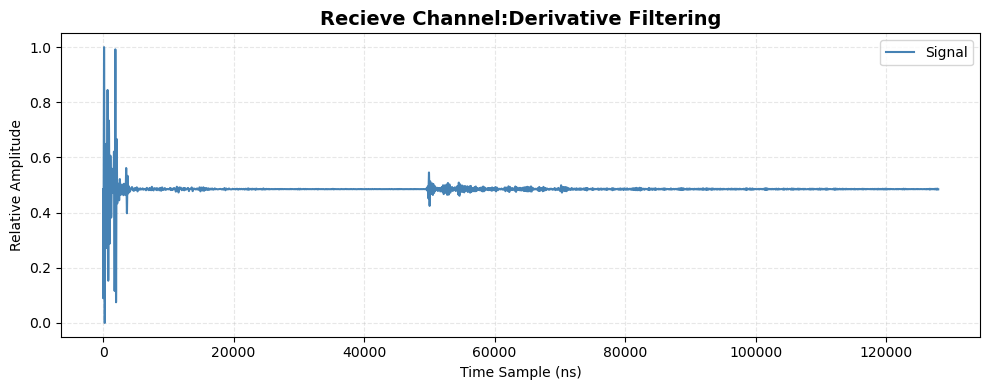

In [43]:
signal_plot(normalized_echo[:],start=0,end=16000,title="Recieve Channel:Derivative Filtering")

In [44]:
squared_output = normalized_echo ** 2


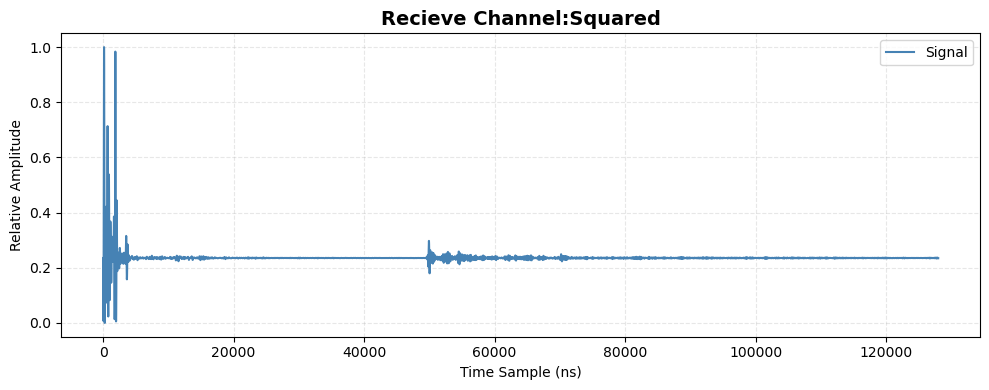

In [45]:
signal_plot(squared_output[:],start=0,end=16000,title="Recieve Channel:Squared")

In [46]:
normalized_squared_output = squared_output / np.max(np.abs(squared_output))


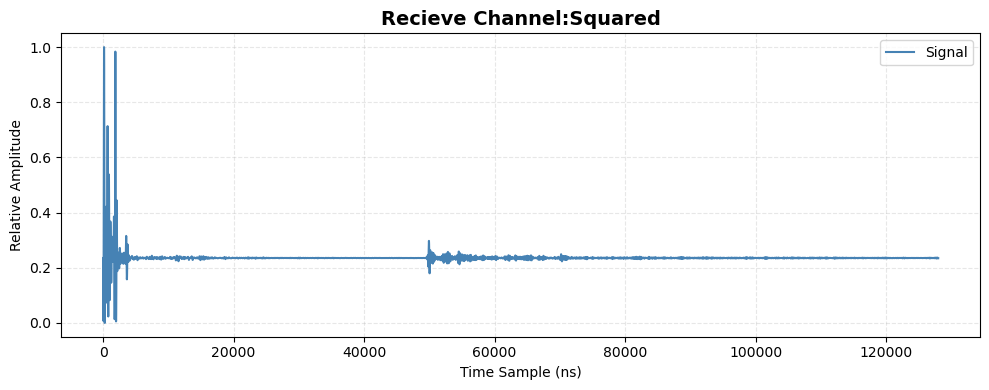

In [47]:
signal_plot(normalized_squared_output[:],start=0,end=16000,title="Recieve Channel:Squared")

In [48]:
normalized_squared_output.shape

(16000,)

In [49]:
integrated_output = moving_average_integrator(normalized_squared_output, window_size=11)

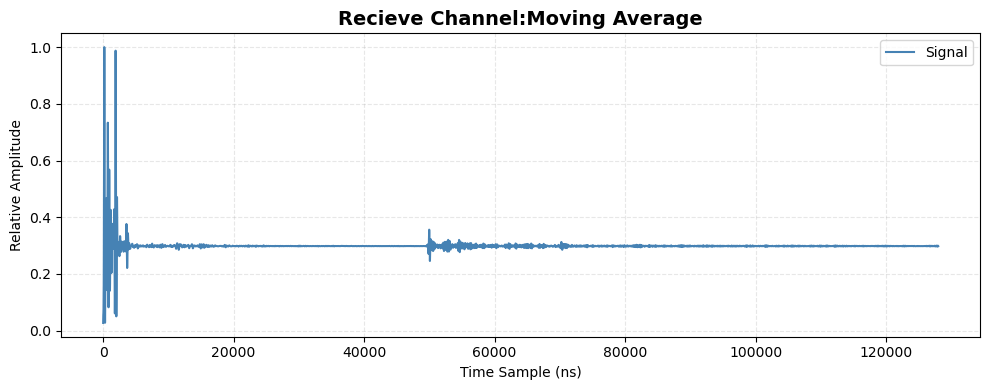

In [50]:
signal_plot(integrated_output[:],start=0,end=16000,title="Recieve Channel:Moving Average")